In [1]:
from sequence import *
from prob import *

In [2]:
distribs = readMultiCount('abf1.jaspar')
distribs

In [3]:
abf1_pwm = PWM(distribs)
abf1_pwm.display()

 	     1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16
A	 -0.82 -25.33 -25.33 -25.33  +0.49  -0.13  +0.44  +0.31  +0.47  +0.51  -0.74 -25.33  +1.30 -25.33  +0.39  +0.31
C	 +0.49  +1.38 -25.33 -25.33  -0.39  -0.04  -0.45  -0.33  -0.17 -25.33  -0.01 -25.33  -1.14  +0.59  -0.13  -0.33
G	 -1.83 -25.33  +1.39 -25.33  -0.13  +0.04  +0.11  -0.22  -0.04  +0.84  -1.03  +1.18 -25.33  -1.02  -0.33  -0.58
T	 +0.57  -3.22 -25.33  +1.39  -0.22  +0.11  -0.39  +0.11  -0.51 -25.33  +0.78  -0.27 -25.33  +0.61  -0.08  +0.31


In [4]:
# read fasta file
yeast_promoters = readFastaFile('yeast_promoters.fa')
len(yeast_promoters)

5850

In [5]:
shorest = 1000
shortest_promoter = ''
for seq in yeast_promoters:
    if len(seq) < shorest:
        shortest_promoter = seq
        shorest = len(seq)
print(shortest_promoter, "with length", shorest)

HIR1: TAAC with length 4


In [6]:
count = 0
for seq in yeast_promoters:
    if len(seq) >= 16:
        count += 1
print(count)

5839


### Search for ABf1 binding sites and their target genes

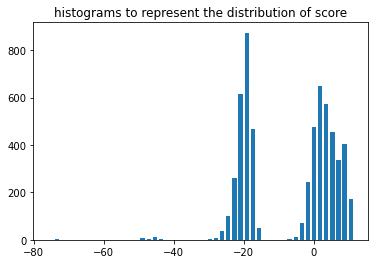

In [7]:
import numpy as np
import matplotlib.pyplot as plt

yeast_promoters = readFastaFile("yeast_promoters.fa", DNA_Alphabet)

distribs = readMultiCount("abf1.jaspar")
abf1_pwm = PWM(distribs)

bind_map = {}
for s in yeast_promoters: # yeast_prom is an array of sequences
    bind_map[s.name] = abf1_pwm.maxscore(s)[0] # save score only
#Create a list of all scores
scores = []
for s in bind_map.keys():
    if bind_map[s] != None:
        scores.append(bind_map[s])

hist, bins = np.histogram(scores, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title("histograms to represent the distribution of score")
    
plt.show()

Find an appropriate scoring threshold that will identify the top ~500 highest scoring genes in your dictionary and then compile their gene names in a list.

In [8]:
scores.sort()
print("threshold:", scores[-500:][0])
threshold = scores[-500:][0]

top500 = []
for s in bind_map.keys():
    if bind_map[s] != None and bind_map[s] >= threshold:
        top500.append(s)
print(top500)

threshold: 8.33724131711271
['ACS1', 'FLC2', 'PTA1', 'PMT2', 'SWC3', 'EFB1', 'YAT1', 'SCS22', 'PET112', 'PRX1', 'KIP1', 'PTC3', 'SEC17', 'PRE7', 'URA7', 'NCL1', 'ACH1', 'SLA1', 'OLA1', 'YBR030W', 'UBP14', 'TSC3', 'SLM4', 'FES1', 'VID24', 'CMD1', 'RAD16', 'MRPL36', 'MRPS9', 'YSY6', 'KTR4', 'NGR1', 'YBR238C', 'DUG2', 'YBR284W', 'VAC17', 'YCL057C-A', 'YCL045C', 'LSB5', 'GBP2', 'CDC10', 'MRPL32', 'PGK1', 'SYP1', 'RBK1', 'THR4', 'HCM1', 'SED4', 'AHC2', 'CSM1', 'CDC39', 'ASF2', 'UGA3', 'STE7', 'YDL144C', 'HNT1', 'UBP1', 'YFH1', 'NUP84', 'NSE4', 'PMT1', 'SRP14', 'SUB2', 'YDL073W', 'BDF2', 'COX9', 'TSR1', 'PBP4', 'SLC1', 'SIT4', 'MPS1', 'RPN4', 'NOP1', 'YDL012C', 'MED2', 'VPS54', 'YDR034C-D', 'YDR034C-C', 'ARO3', 'BAP3', 'SED1', 'PDC2', 'RLI1', 'TRM1', 'FIN1', 'MKC7', 'KGD2', 'SUP35', 'NGG1', 'YDR186C', 'MSS116', 'MSC2', 'UME6', 'LYS4', 'MNN10', 'SWM1', 'YDR262W', 'DPP1', 'ZIP1', 'HDA2', 'CFT1', 'SUM1', 'TFB1', 'YSP2', 'PEX3', 'MRP1', 'ATP22', 'EAF1', 'VPS74', 'YDR374W-A', 'RPP2B', 'EFT2', 'NC

### Perform Gene Ontology (GO) enrichment tests on target genes

In [9]:
from godata import GO

positive_gene_list = top500

go = GO("gene_association.sgd", "goslim_yeast.obo", (2,2,3,4,6,8))
negative_gene_list = list(go.getAllBackground(positive_gene_list)[0])[:1000]

('Started at', 'Tue May 11 13:49:17 2021')
Read 167 GO definitions
Read annotations for 6448 genes


In [18]:
report = go.getEnrichmentReport(positive_gene_list, negative_gene_list, threshold = 50.0, include_more_general = True)
go_list = []
for row in report:
    print(row)
    go_list.append(row[0])
print(go_list)

('GO:0003729', 0.2269100857839811, 30, 51, 'mRNA binding', 'F')
('GO:0006351', 0.362341265350927, 62, 129, 'Unknown', 'Unknown')
('GO:0005634', 0.8422227487411286, 212, 547, 'nucleus', 'C')
('GO:0005628', 1.3217681222265272, 12, 16, 'Unknown', 'Unknown')
('GO:0001056', 2.386394406838901, 6, 6, 'Unknown', 'Unknown')
('GO:0042797', 2.386394406838901, 6, 6, 'Unknown', 'Unknown')
('GO:0005666', 2.386394406838901, 6, 6, 'Unknown', 'Unknown')
('GO:0003899', 2.7988515587237632, 10, 13, 'Unknown', 'Unknown')
('GO:0000932', 6.616133984771947, 9, 12, 'Unknown', 'Unknown')
('GO:0015616', 7.207393208528802, 5, 5, 'Unknown', 'Unknown')
('GO:0003968', 11.970307687311738, 6, 7, 'Unknown', 'Unknown')
('GO:0006458', 11.970307687311738, 6, 7, 'Unknown', 'Unknown')
('GO:0051603', 11.970307687311738, 6, 7, 'proteolysis involved in cellular protein catabolic process', 'P')
('GO:0001172', 11.970307687311738, 6, 7, 'Unknown', 'Unknown')
('GO:0006303', 11.970307687311738, 6, 7, 'Unknown', 'Unknown')
('GO:0030

In [22]:
# go more information by getTermdef
for term in go_list:
    defin = go.getTermdef(term)
    print(defin)

('F', {('GO:0003723', 'is_a')}, 'mRNA binding')
('Unknown', 'Unknown', 'Unknown')
('C', {('GO:0005575', 'is_a'), ('GO:0005575', 'part_of')}, 'nucleus')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('P', {('GO:0008150', 'part_of'), ('GO:0008150', 'is_a')}, 'proteolysis involved in cellular protein catabolic process')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', 'Unknown', 'Unknown')
('Unknown', '